In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 하이퍼파라미터
EPOCHS = 500
BATCH_SIZE = 512
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [3]:
# Fashion MNIST 데이터셋
trainset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    drop_last = True
)

In [4]:
# 생성자 (Generator)
G = nn.Sequential(
        nn.Linear(100, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Tanh())

In [5]:
# 판별자 (Discriminator)
D = nn.Sequential(
        nn.Linear(784, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid())

In [6]:
# 모델의 가중치를 지정한 장치로 보내기
# CUDA(GPU) / CPU
D = D.to(DEVICE)
G = G.to(DEVICE)

# 이진 크로스 엔트로피 (Binary cross entropy) 오차 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [7]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)# [1,1,1...]
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)# [0.0,0...]
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차를 예산
        outputs = D(images) # 진짜 이미지를 discriminator의 입력으로 제공
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        fake_images = G(z) #G의 입력으로 랜덤 텐서 제공, G가 fake image 생성
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images)# 가짜 이미지를 discriminator의 입력으로 제공
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 Discriminator의 오차 계산
        d_loss = d_loss_real + d_loss_fake

        #------ Discriminator 학습 ------#
        # 역전파 알고리즘으로 Discriminator의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()# Discriminator 학습
        
        # 생성자가 판별자를 속였는지에 대한 오차(Generator의 loss)를 계산
        fake_images = G(z)
        outputs = D(fake_images) #한번 학습한 D가 fake image를 
        g_loss = criterion(outputs, real_labels) #y=1로 주는 이유가 -log하기위해서?

         #------ Generator 학습 ------#
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

Epoch [0/500], d_loss: 0.1920, g_loss: 2.9702, D(x): 0.96, D(G(z)): 0.13
Epoch [1/500], d_loss: 0.0339, g_loss: 4.2083, D(x): 0.99, D(G(z)): 0.03
Epoch [2/500], d_loss: 0.1766, g_loss: 4.5945, D(x): 0.94, D(G(z)): 0.09
Epoch [3/500], d_loss: 0.0900, g_loss: 5.7546, D(x): 0.96, D(G(z)): 0.04
Epoch [4/500], d_loss: 0.0409, g_loss: 5.0568, D(x): 0.98, D(G(z)): 0.02
Epoch [5/500], d_loss: 0.0411, g_loss: 5.0654, D(x): 0.99, D(G(z)): 0.03
Epoch [6/500], d_loss: 0.1924, g_loss: 6.0582, D(x): 0.97, D(G(z)): 0.10
Epoch [7/500], d_loss: 0.1665, g_loss: 4.8337, D(x): 0.95, D(G(z)): 0.08
Epoch [8/500], d_loss: 0.2022, g_loss: 5.3041, D(x): 0.93, D(G(z)): 0.08
Epoch [9/500], d_loss: 0.1318, g_loss: 4.3358, D(x): 0.97, D(G(z)): 0.08
Epoch [10/500], d_loss: 0.2710, g_loss: 3.9043, D(x): 0.93, D(G(z)): 0.12
Epoch [11/500], d_loss: 0.1999, g_loss: 4.8792, D(x): 0.95, D(G(z)): 0.07
Epoch [12/500], d_loss: 0.1409, g_loss: 4.5337, D(x): 0.96, D(G(z)): 0.07
Epoch [13/500], d_loss: 0.7745, g_loss: 3.3441, 

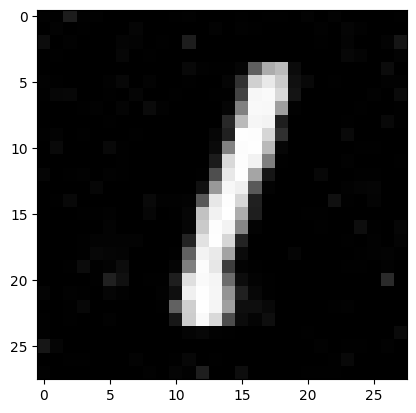

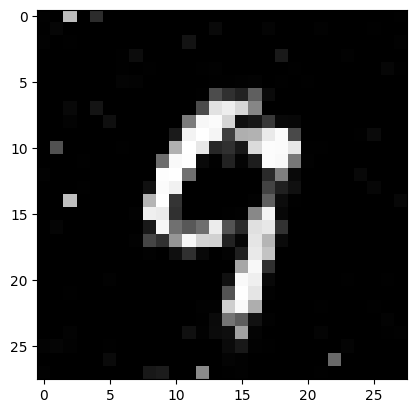

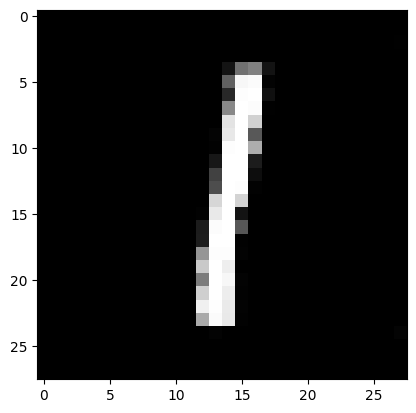

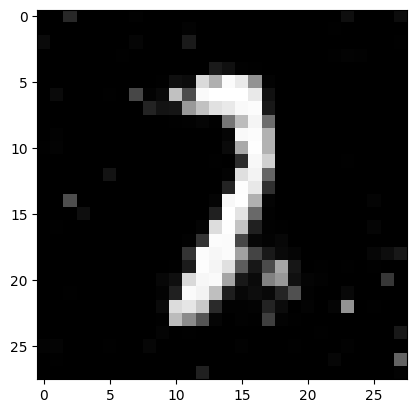

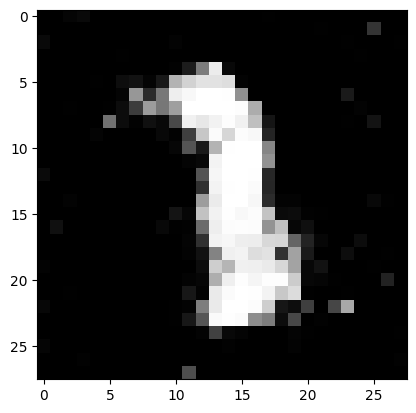

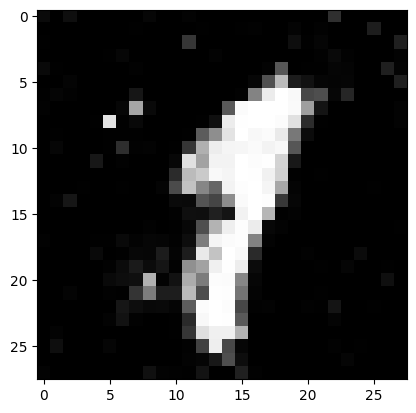

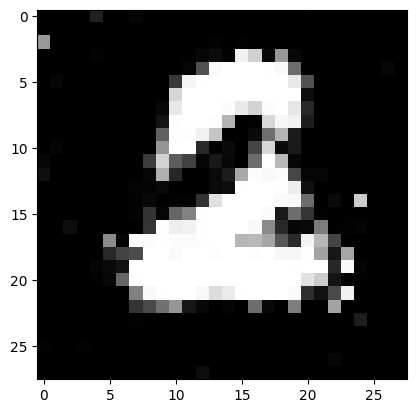

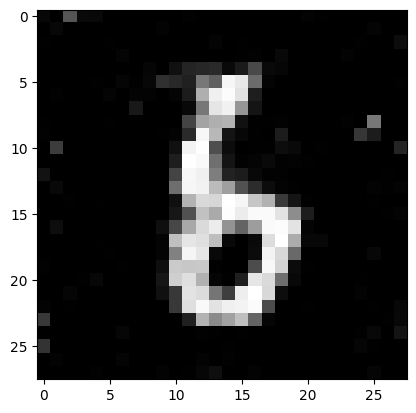

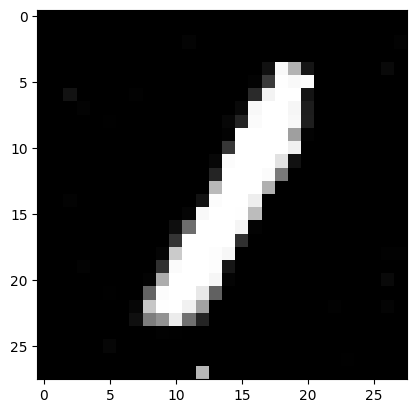

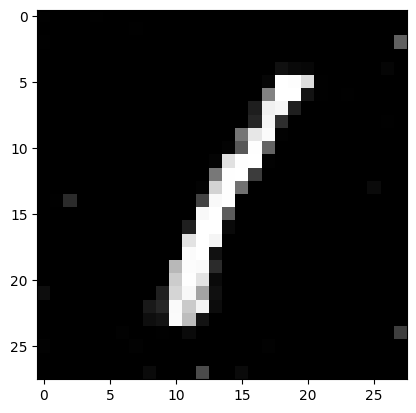

In [8]:
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()